In [5]:
import pandas as pd
import cv2
import sys
import matplotlib.pyplot as plt

sys.path.append(r"D:\MSc Works\temp_matching")
# else cant load model
from temp_matching.model import CustomUnet, EncodingCombination

In [107]:
import pandas as pd
from pathlib import Path

# Path to the CSV file
csv_path = r"D:\MSc Works\temp_matching\assets\model_results2\results.csv"

# Read the raw content of the CSV file
with open(csv_path, "r") as file:
    raw_content = file.readlines()

# Replace commas inside parentheses in the bbox column
processed_content = []
for line in raw_content:
    start = line.find("(")
    end = line.find(")")
    if start != -1 and end != -1:
        bbox = line[start : end + 1]
        bbox_cleaned = bbox.replace(",", "|")  # Replace commas with '|'
        line = line.replace(bbox, bbox_cleaned)
    processed_content.append(line)

# Write the processed content back to a temporary file (optional)
with open("processed_results.csv", "w") as file:
    file.writelines(processed_content)

# Create a DataFrame from the processed content
data = [line.strip().split(",") for line in processed_content]
header = data[0]
rows = data[1:]
df = pd.DataFrame(rows, columns=header)

# Restore the original bbox format in the DataFrame
df["bbox"] = df["bbox"].str.replace("|", ",")

# Display the DataFrame
print(df.head())

                                          image_name       label  \
0  D:/MSc Works/temp_matching/assets/training_dat...         dog   
1  D:/MSc Works/temp_matching/assets/training_dat...      toilet   
2  D:/MSc Works/temp_matching/assets/training_dat...         dog   
3  D:/MSc Works/temp_matching/assets/training_dat...  motorcycle   
4  D:/MSc Works/temp_matching/assets/training_dat...         dog   

                   bbox model_iou   ann_id          model_time  \
0  (272, 200, 151, 279)     0.855     1773  0.7074347468750375   
1    (174, 0, 261, 220)     0.003  1097222  0.7074347468750375   
2  (124, 196, 372, 356)     0.885     2551  0.7074347468750375   
3    (59, 50, 501, 390)     0.922   148804  0.7074347468750375   
4  (112, 154, 367, 479)     0.964     3186  0.7074347468750375   

  model_gpu_memory model_memory sift_iou            sift_time  
0        13.129328   492.639872      1.0    0.079551699996955  
1        13.129328   492.639872      1.0  0.07788540000183275  
2 

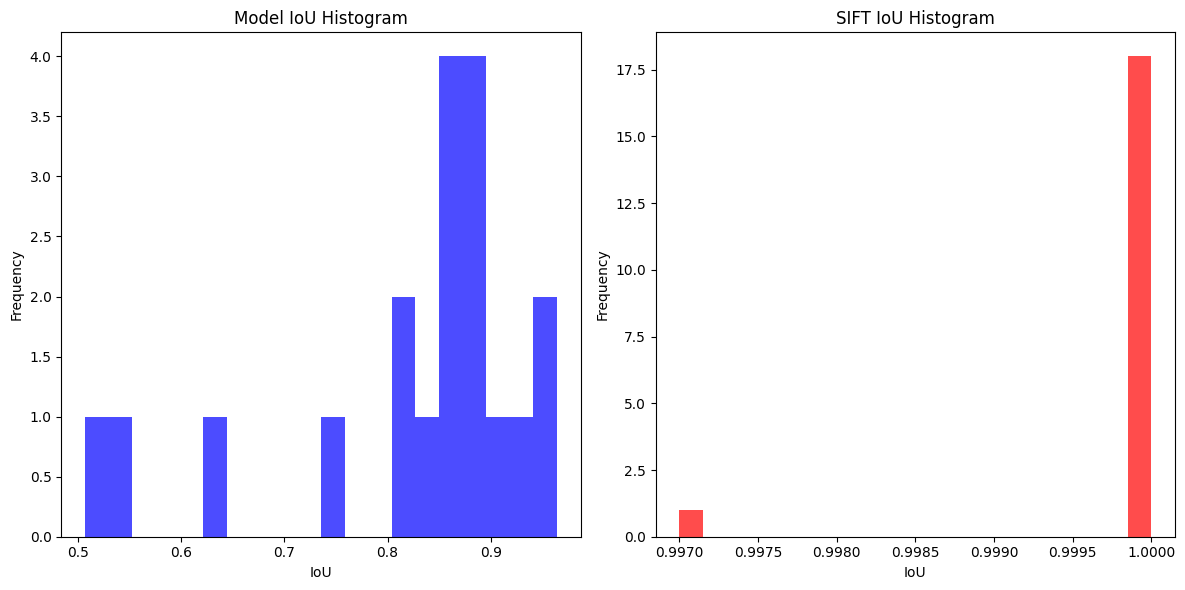

In [122]:
df.model_iou = df.model_iou.astype(float)
df.sift_iou = df.sift_iou.astype(float)
df.sift_time = df.sift_time.astype(float)
df.model_time = df.model_time.astype(float)

ndf = df[df.model_iou > 0.5]
# ndf = ndf[ndf.sift_iou > 0.5]
# Plot the IoU values for the model and SIFT in subplots

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ndf.model_iou.plot.hist(ax=axes[0], bins=20, color="blue", alpha=0.7)
axes[0].set_title("Model IoU Histogram")
axes[0].set_xlabel("IoU")
axes[0].set_ylabel("Frequency")

ndf.sift_iou.plot.hist(ax=axes[1], bins=20, color="red", alpha=0.7)
axes[1].set_title("SIFT IoU Histogram")
axes[1].set_xlabel("IoU")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

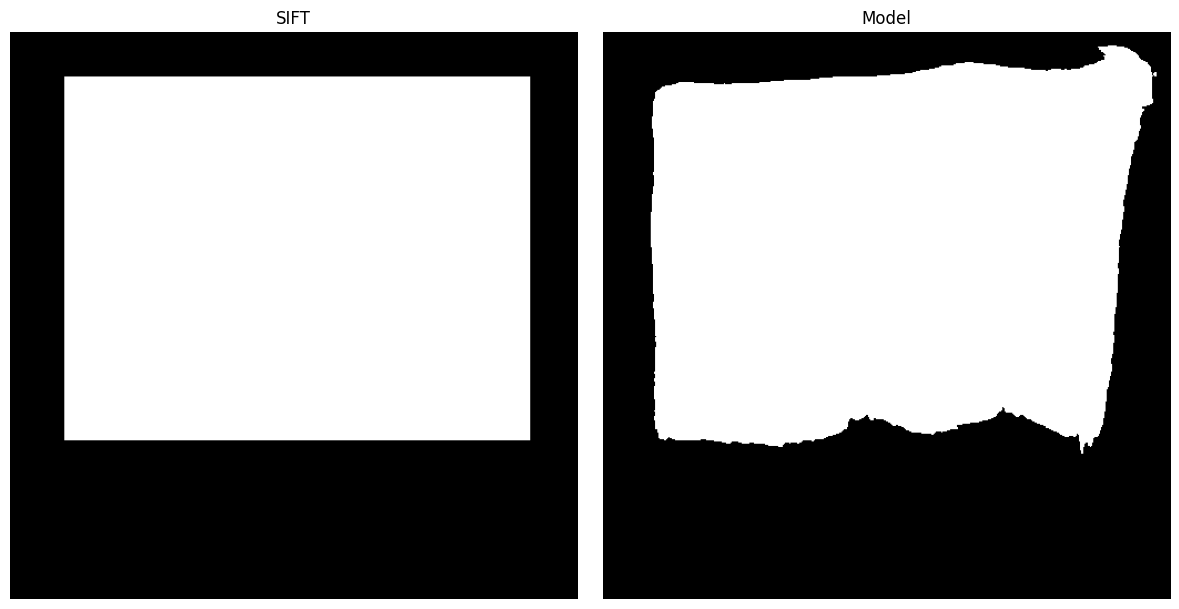

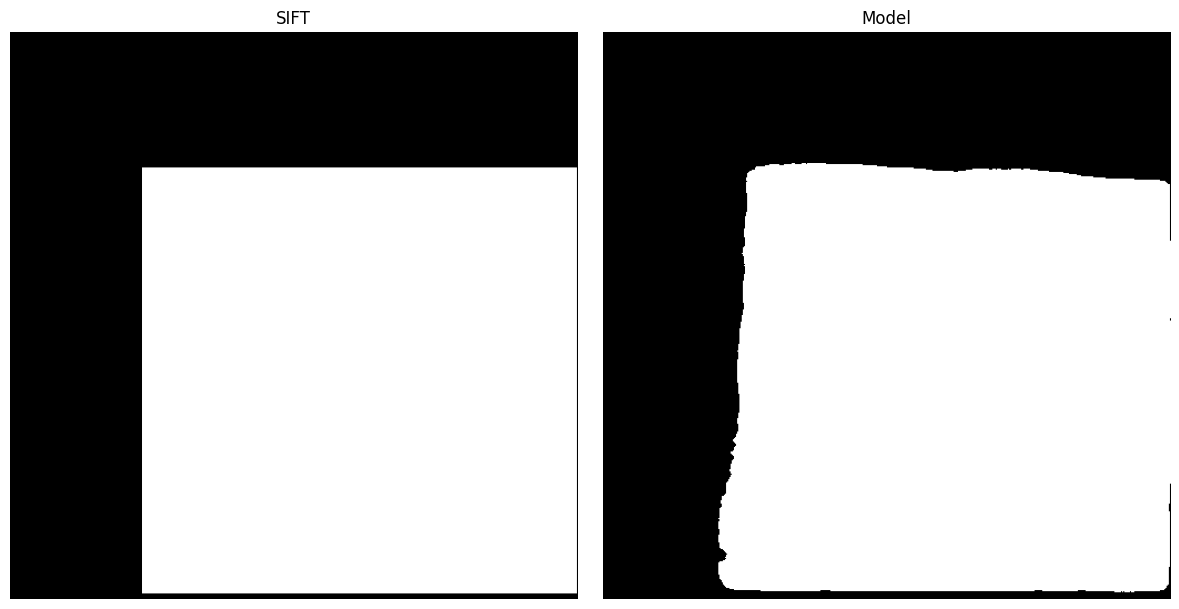

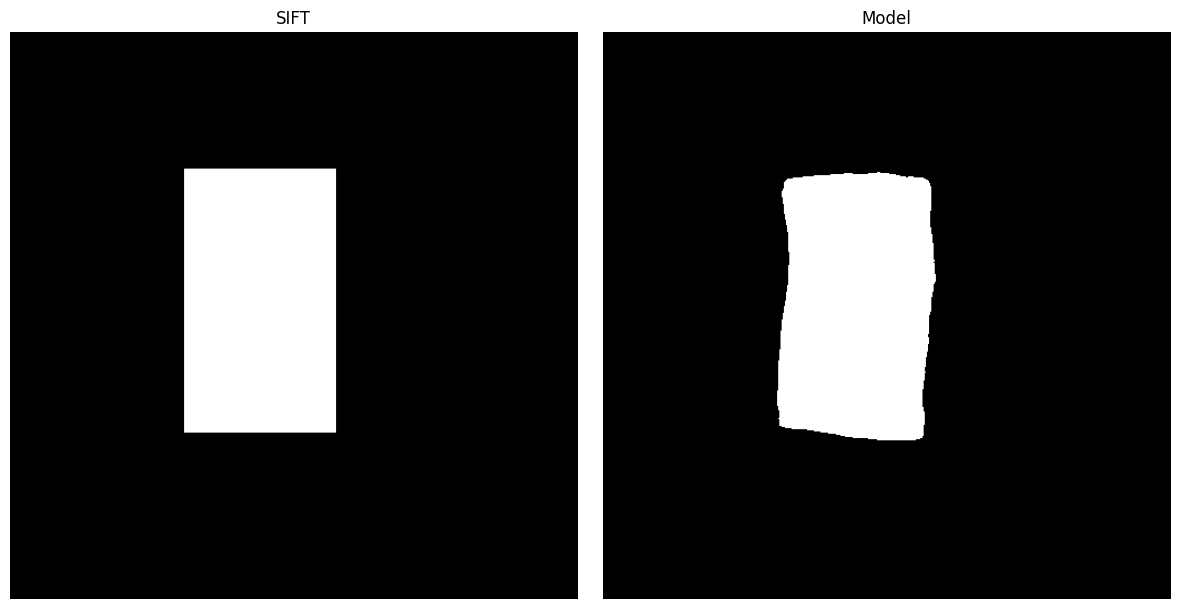

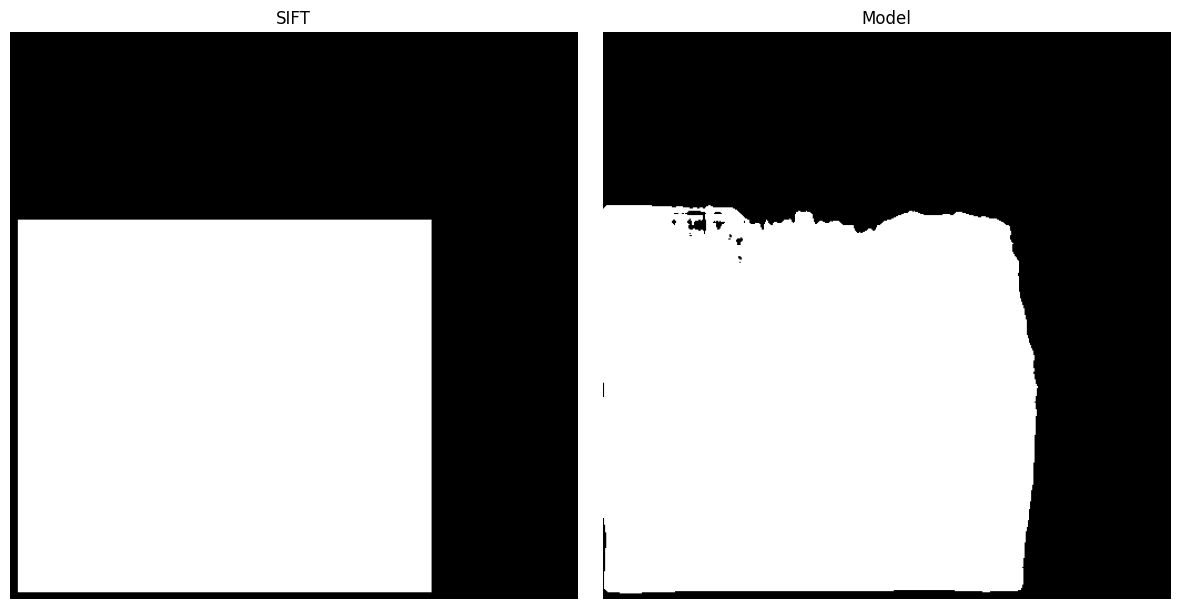

In [123]:
import numpy as np

max = 5
itr = 0
result_dir = Path("D:/MSc Works/temp_matching/assets/model_results2")
for idx, row in df.query("model_iou>0.9").iterrows():
    # print(row)
    filename = Path(row["image_name"]).stem
    sift_path = result_dir / f"{filename}_{row['ann_id']}_sift.npy"
    model_path = result_dir / f"{filename}_{row['ann_id']}_model.npy"
    sift = np.load(sift_path)
    model = np.load(model_path)
    sift = sift.astype(np.uint8) * 255
    model = model.astype(np.uint8) * 255

    sift = cv2.cvtColor(sift, cv2.COLOR_BGR2RGB)
    model = cv2.cvtColor(model, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(sift)
    axes[0].set_title("SIFT")
    axes[0].axis("off")
    axes[1].imshow(model)
    axes[1].set_title("Model")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    itr += 1
    if itr == max:
        break

In [118]:
(255 * sift.astype(np.uint8)).max()

255

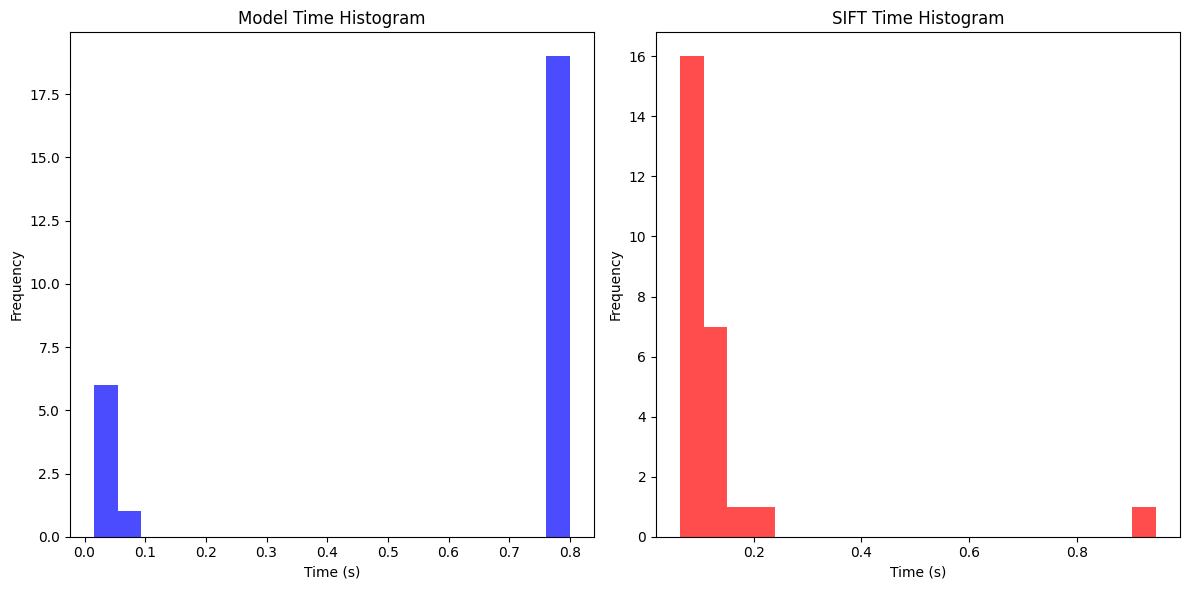

In [84]:
# Plot the time taken by the model and SIFT in subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ndf.model_time.plot.hist(ax=axes[0], bins=20, color="blue", alpha=0.7)
axes[0].set_title("Model Time Histogram")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency")

ndf.sift_time.plot.hist(ax=axes[1], bins=20, color="red", alpha=0.7)
axes[1].set_title("SIFT Time Histogram")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [106]:
# count the number of rows with model_iou > 0.5 and sift_iou > 0.5
model_iou_count = (df.model_iou > 0.9).sum()
sift_iou_count = (df.sift_iou > 0.9).sum()

print(f"Model IoU > 0.5: {model_iou_count}")
print(f"SIFT IoU > 0.5: {sift_iou_count}")

Model IoU > 0.5: 4
SIFT IoU > 0.5: 84
